In [1]:
import arcpy
import json
import numpy as np

# Open raster dataset as MDim [Raster](https://pro.arcgis.com/en/pro-app/arcpy/classes/raster-object.htm)

currently support netcdf, mdim CRF and multidimensional mosaic dataset as input
#### Properties
    * isMultidimensional
    * mdinfo
    * slices
    * variables
    * variableNames
----------
#### Methods
    * getVariableAttributes(variable_name)
    * getDimensionNames(variable_name)
    * getDimensionAttributes(variable_name, dimension_name)
    * getDimensionValues(variable_name, dimension_name)
    * save({name})

In [2]:
#in_raster_path = r"C:\Users\greg6750\Documents\IPython Notebooks\developing-with-imagery\Data\NetCDF\daymet_v3_tmin_monavg_2017_na.nc4"
in_raster_path = r"D:\DATA\USFS\DAYMET\TEMP\daymet_v3_tmin_2017.crf"
# load the raster dataset as a mdim raster
myRaster=arcpy.Raster(in_raster_path, True)
myRaster.variables[0]

'tmin(StdTime=12)'

## Get a Pixel Value at a Location

In [3]:
arcpy.GetCellValue_management(myRaster, location_point="0 0")

<Result '-10.419354'>

## Preview the image

We preview the dataset and only see a single raster. In order to see all the rasters, we need to create slices.

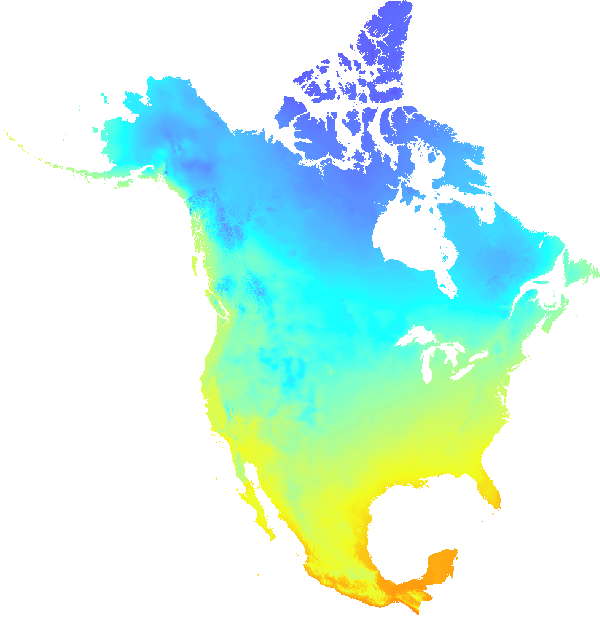

In [4]:
out_raster = arcpy.ia.Subset(myRaster, variables='tmin')
out_raster

In [5]:
# check whether it is multidimensional
myRaster.isMultidimensional

True

In [6]:
# list the variables  
myRaster.variables

['tmin(StdTime=12)']

In [7]:
# check the dimension attribute
myRaster.getDimensionAttributes('tmin', 'StdTime')

{'Unit': 'ISO8601',
 'HasRegularIntervals': False,
 'Interval': 30.0,
 'IntervalUnit': 'Days',
 'Minimum': '2017-01-16T12:00:00+00:00',
 'Maximum': '2017-12-17T00:00:00+00:00',
 'HasRanges': False}

In [8]:
# check the dimension values
myRaster.getDimensionValues('tmin', 'StdTime')

['2017-01-16T12:00:00+00:00',
 '2017-02-15T12:00:00+00:00',
 '2017-03-17T12:00:00+00:00',
 '2017-04-17T00:00:00+00:00',
 '2017-05-17T12:00:00+00:00',
 '2017-06-17T00:00:00+00:00',
 '2017-07-17T12:00:00+00:00',
 '2017-08-17T12:00:00+00:00',
 '2017-09-17T00:00:00+00:00',
 '2017-10-17T12:00:00+00:00',
 '2017-11-17T00:00:00+00:00',
 '2017-12-17T00:00:00+00:00']

In [9]:
myRaster.getDimensionValues('tmin', 'StdTime')[0]

'2017-01-16T12:00:00+00:00'

## View July 2017

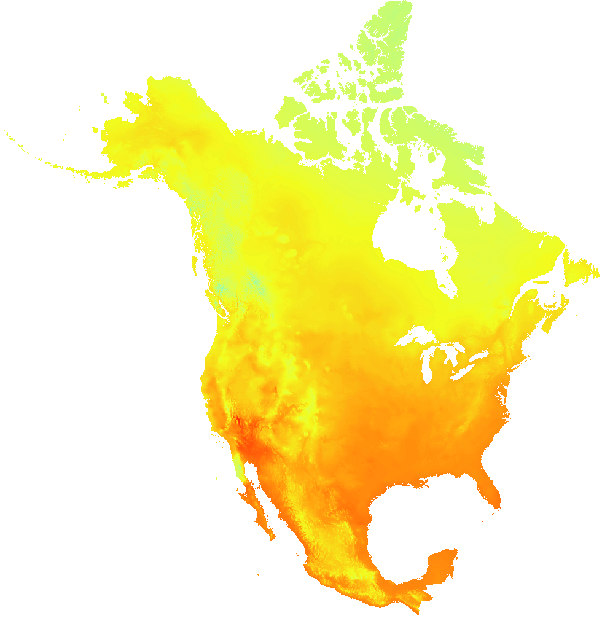

In [11]:
out_raster_subset = arcpy.ia.Subset(myRaster, 
                                    variables='tmin', 
                                    dimension_definitions = {'stdTime': myRaster.getDimensionValues('tmin', 'StdTime')[6]})   
out_raster_subset

## View all the years sequentially

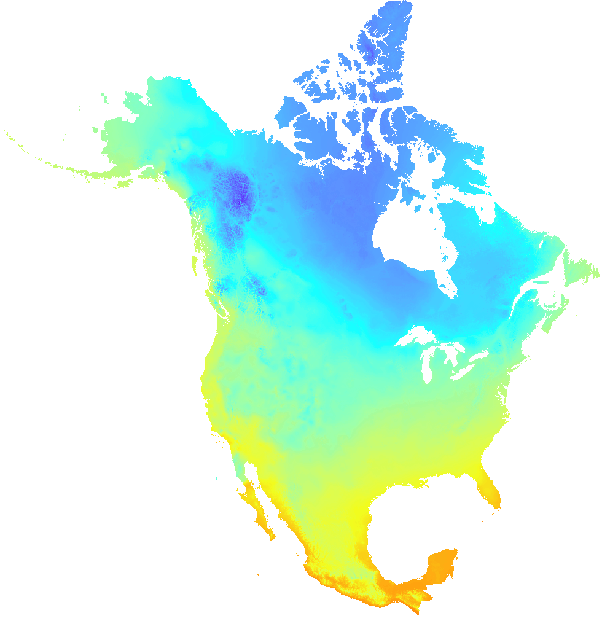

In [14]:
import time
from IPython.display import display, clear_output

for dim_val in myRaster.getDimensionValues('tmin', 'StdTime'):
    clear_output(wait=True)
    out_raster_subset = arcpy.ia.Subset(myRaster, variables='tmin', dimension_definitions = {'stdTime': dim_val})   
    
    display(out_raster_subset)
    time.sleep(.1)

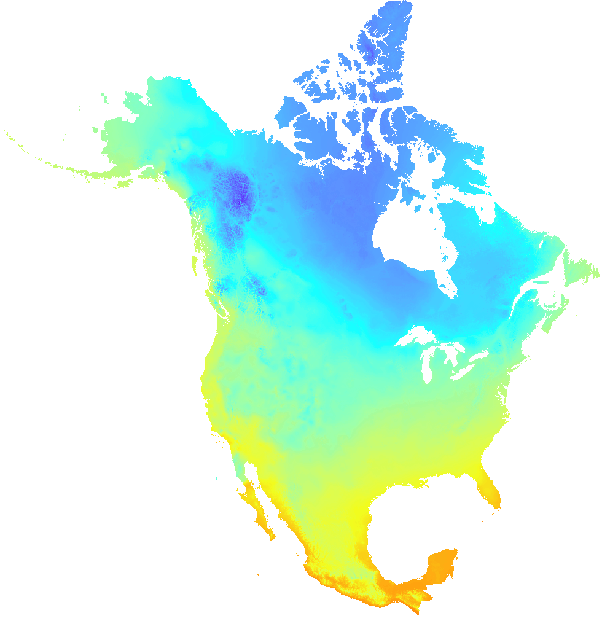

In [15]:
import time
from IPython.display import display, clear_output

for i in range(12):
    clear_output(wait=True)
    out_raster_subset = arcpy.ia.Subset(myRaster, variables='tmin', dimension_definitions = {'stdTime': myRaster.getDimensionValues('tmin', 'StdTime')[i]})   
    
    display(out_raster_subset)
    time.sleep(.1)
    

# Subset Raster to Numpy Array

In [16]:
arr = arcpy.RasterToNumPyArray(out_raster_subset)
#out_raster_subset

## Extracting temperature (pixel) values

In [17]:
for dim_val in myRaster.getDimensionValues('tmin', 'StdTime'):
    out_raster_subset = arcpy.ia.Subset(myRaster, variables='tmin', dimension_definitions = {'stdTime': dim_val})   
    #out_raster_subset = arcpy.ia.Subset(myRaster, variables='tmin', dimension_definitions = {'stdTime': myRaster.getDimensionValues('tmin', 'StdTime')[i]})   
    
    print(arcpy.GetCellValue_management(out_raster_subset, location_point="0 0"))

-10.419354
-6.6206899
-2.4516129
2.05
6.6129031
12.833333
17.725807
13.193548
10.016666
1.9354838
-2.6166666
-9.416667


------------
# 2. Functions in arcpy.ia
  * Subset
  * Aggregate
  * Apply
  ----------
## 2.1. Subset(in_raster, {variables}, {dimension_definitions})
https://pro.arcgis.com/en/pro-app/arcpy/image-analyst/subset.htm

Filter the mdim raster along variables or/and dimensions.<br>
The paramter **variables** supports single variable name or a list of variable names <br>
 * varialbes = varaible_name
 * variables = [variable_name,...] <br>


The parameter **dimension_definitions** support dict input as below <br>
 * {dimension_name: value, ...}
 * {dimension_name: (min, max),...}
 * {dimension_name:[value1, (min1, max1), …], ...}
 * {dimension_name:(from, to, recurrent_interval_size, recurrent_interval_unit), ...}
    * recurrently select single slice if to = None
    * otherwise, it means recurrently select ranges

------------------
## 2.2. Aggregate(in_raster, dimension_name, raster_function, {raster_function_arguments}, {aggregation_definition})
https://pro.arcgis.com/en/pro-app/arcpy/image-analyst/aggregate.htm

Aggregate mdim raster based on user specified dimension intervals and aggregation method<br>
The paramter aggregation_def defines how slices are grouped
 * {"interval": interval_keyword}
     * interval_keyword includes hourly, daily, weekly, monthly, yearly 
 * {"interval_value": value, "interval_unit": unit}
 * {"interval_ranges": [(min,max),(min,max), ...]}
 * {"recurrent_interval": recurrent_keyword} 
     * recurrent_keyword includes quarterly, monthly, weekly, daily

In [18]:
arcpy.CheckOutExtension("ImageAnalyst")

'CheckedOut'

In [19]:
in_raster_path = r"D:\DATA\USFS\DAYMET\TEMP\daymet_v3_tmin_2017.crf"

# load the raster dataset as a mdim raster
tminRaster=arcpy.Raster(in_raster_path, True)
tminRaster.variables

['tmin(StdTime=12)']

### Aggregate along the whole time range using a *Mean* function

In [20]:
avg_tmin = arcpy.ia.Aggregate(tminRaster, 'StdTime', 'Mean')
avg_tmin.variables

['tmin(StdTime=1)']

### Render the result

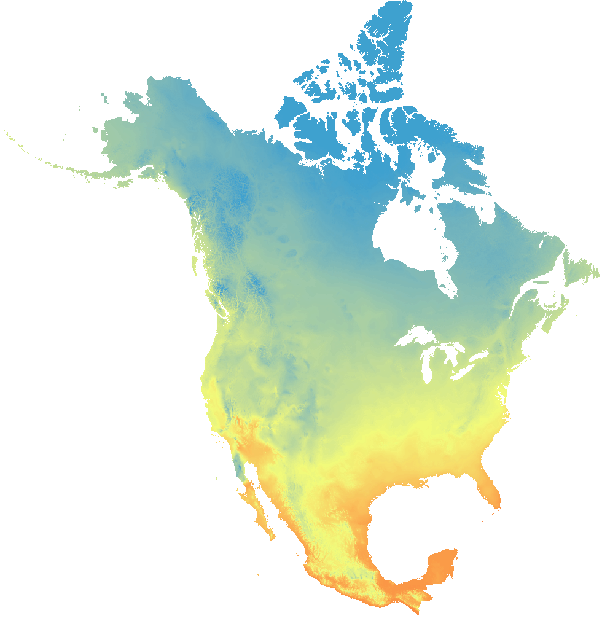

In [21]:
arcpy.ia.Render(avg_tmin, 
                rendering_rule = {"min": -15, "max": 35}, 
                colormap = "Prediction")

### Aggregate along the whole time range using a *Min* function

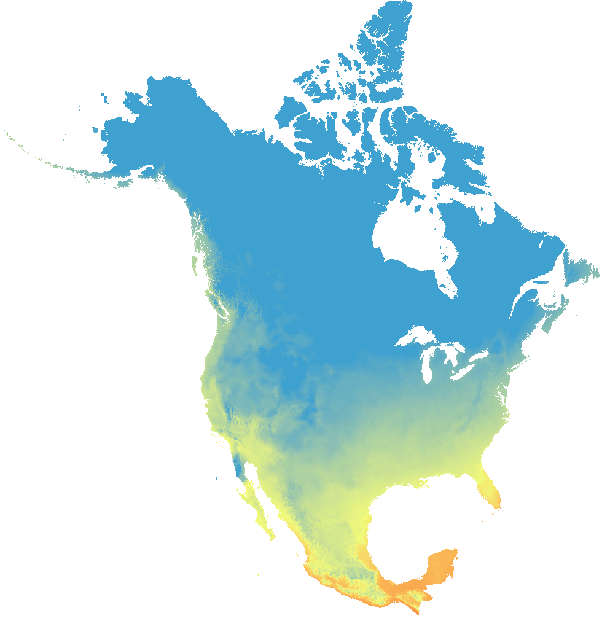

In [22]:
# calc the average precipitation in 1980
min_tmin = arcpy.ia.Aggregate(tminRaster, 'StdTime', 'Min')
arcpy.ia.Render(min_tmin,
                rendering_rule = {"min": -15, "max": 35}, 
                colormap = "Prediction")

###  Aggregate along the whole time range using a *Max* function

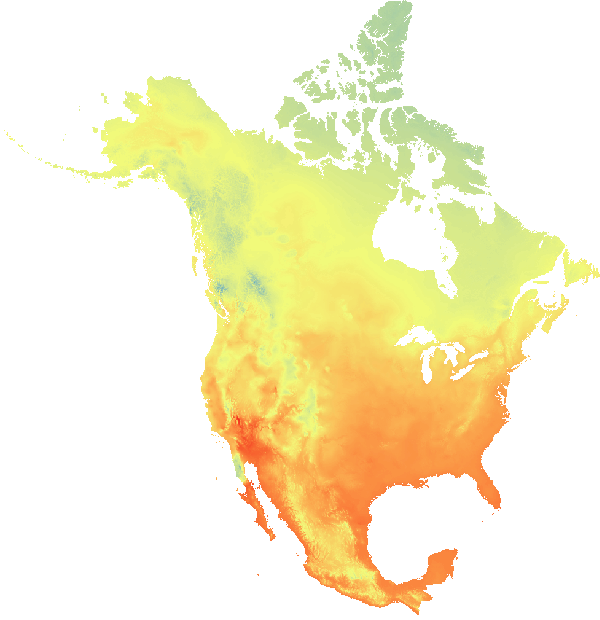

In [23]:
# calc the average precipitation in 1980
max_tmin = arcpy.ia.Aggregate(tminRaster, 'StdTime', 'Max')
arcpy.ia.Render(max_tmin,
                rendering_rule = {"min": -15, "max": 35}, 
                colormap = "Prediction")

### Aggregate into seasonal means

In [24]:
# calc the average precipitation within every 15 days in 1980
avg_prcp_every_15days = arcpy.ia.Aggregate(tminRaster, 'StdTime', 'Mean', aggregation_definition = {"interval_value": 90, "interval_unit":'day'})
avg_prcp_every_15days.variables

['tmin(StdTime=4)']

In [25]:
arcpy.CheckInExtension("ImageAnalyst")

'CheckedIn'

----------------
### 2.3. Apply(in_raster, raster_function, {raster_function_arguments})
https://pro.arcgis.com/en/pro-app/arcpy/image-analyst/apply.htm

apply a builtin raster function or customized python raster function, or function chain to single raster or several rasters. It works with multidimensional as well as non-multidimensional raster(s)<br>
the parameter in_raster has 4 different fomats
 * single raster 
  * for those functions that need one raster input, e.g., NDVI
 * (raster1, raster2) 
  * for those functions that have 2 raster inputs: Raster and Raster2, e.g., Arithmetic
 * [raster1, raster2, …] 
  * for those functions that need an array of raster inputs: Rasters, e.g.,CompositeBand
 * {var_name1: raster1, var_name2: raster2, …}
  * for those functions that need a set of named raster inputs, e.g., HeatIndex
 
the paramter raster_function could be a built-in raster function name or a function template (.rft.xml)

## Using a Mosaic Dataset as Input

In [26]:
in_raster_path = r'C:\Users\greg6750\Documents\ArcGIS\Projects\NetCDFs\NetCDFs.gdb\t_min'
myRaster=arcpy.Raster(in_raster_path, True)
myRaster.variables[0]

'tmin(StdTime=60)'

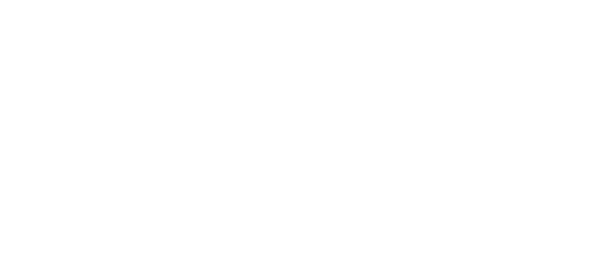

In [27]:
import time
from IPython.display import display, clear_output

for i in range(60):
    clear_output(wait=True)
    out_raster_subset_2 = arcpy.ia.Subset(myRaster, 
                                        variables='tmin', 
                                        dimension_definitions = {'stdTime': myRaster.getDimensionValues('tmin', 'StdTime')[i]})   
    
    display(out_raster_subset_2)
    time.sleep(.1)